In [161]:
# store start time to get execution time of entire script
import time
start_time = time.time()

In [162]:
# helper functions for displaying table data

import numpy as np
from IPython.display import display_html

# n is the number of columns to display data in
def display_side_by_side(series_obj, n):
    df = pd.DataFrame(series_obj)
    partition = int(round(len(df) / n))
    lower_bound = 0
    upper_bound = partition
    args = []
    for i in range(n):
        args.append(df[lower_bound:upper_bound])
        lower_bound += partition
        upper_bound += partition
    helper(args)

def helper(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [163]:
# helper function for plotting out ground truth curves

import matplotlib.pyplot as plt

def get_ground_truth(data):
    relapsed = data[data.Illicit_Cens5 == 1]
    counts = relapsed['Illicit_Days5'].value_counts()
    counts = counts.to_dict()
    temp = [len(data)] * 365
    labels = list(range(365))
    for i in range(365):
        labels[i] += 1
    total = 0
    errors = []
    for i in range(365):
        try:
            temp[i] = temp[i] - counts[i+1] - total
            total = total + counts[i+1]
        except KeyError:
            errors.append(i)

    for ele in sorted(errors, reverse = False):
        if ele != 0:
            temp[ele] = temp[ele-1]
        else:
             temp[0] = len(data)
    temp = [x / len(data) for x in temp]
    return labels, temp

In [164]:
from sklearn.model_selection import cross_validate
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis

def run_models(X, y, label):
    gbsa = GradientBoostingSurvivalAnalysis()
    scores = cross_validate(gbsa, X, y, cv=5)
    gbsa_score = scores['test_score'].mean()
    print('RF Boosted score:', gbsa_score)
    
    gbsa = GradientBoostingSurvivalAnalysis()
    gbsa.fit(X, y)
    
    rsf = RandomSurvivalForest()
    scores = cross_validate(rsf, X, y, cv=5)
    rsf_score = scores['test_score'].mean()
    print('RF score:', rsf_score)
    
    rsf = RandomSurvivalForest()
    rsf.fit(X, y)
    
    # l1_ratio = 1 adjusts model to implement LASSO method for penalties
    rcr = CoxnetSurvivalAnalysis(l1_ratio=1)
    scores = cross_validate(rcr, X, y, cv=5)
    rcr_score = scores['test_score'].mean()
    print('Lasso score:', rcr_score)
    
    # fit_baseline_model = True allows us to create survival/hazard plots after model is fit
    rcr = CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=1)
    rcr.fit(X, y)
    
    # concordance index
    scores = {'Model': ['Random Forest Boosted','Random Forest','Lasso','Dataset Size'], 
              label: [gbsa_score,rsf_score,rcr_score,X.shape[0]]}
    
    concordance = pd.DataFrame(data=scores)
    
    # return scores and models
    return concordance, gbsa, rsf, rcr

In [165]:
def get_survival_graph(rsf, rcr, X, Y, label, filename):
    pred_surv_rsf = rsf.predict_survival_function(X)
    pred_surv_rcr = rcr.predict_survival_function(X)
    
    # display survival plot
    plt.suptitle(label)
    plt.plot(np.mean([person for person in pred_surv_rsf], axis=0), label='RF')
    plt.plot(np.mean([person.y for person in pred_surv_rcr], axis=0), label='Lasso')
    labels, temp = get_ground_truth(Y)
    plt.plot(labels, temp, label='Ground Truth')
    plt.legend()
    plt.xlim(0, 365)
    plt.xticks(np.arange(0, 365, step=50))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.savefig(filename)
        
    plt.show()

In [166]:
def get_feature_importance(features, gbsa, rcr, label):
    # feature importances from Boosted Random Forest
    feature_importance_rf = pd.DataFrame({'Feature':features, label:gbsa.feature_importances_,})
    feature_importance_rf.sort_values(by=[label], ascending=False, inplace=True)
    feature_importance_rf = feature_importance_rf.nlargest(10,[label]) # keep top 10 features
    feature_importance_rf = feature_importance_rf[feature_importance_rf[label] != 0]

    # feature importances from Lasso
    feature_importance_lasso = pd.DataFrame({'Feature':features,
                                                  label:np.average(rcr.coef_, weights=rcr.alphas_, axis = 1),})
    feature_importance_lasso[label + '_abs'] = np.absolute(feature_importance_lasso[label])
    feature_importance_lasso = feature_importance_lasso.nlargest(10,[label + '_abs']) # keep top 10 features
    feature_importance_lasso = feature_importance_lasso[feature_importance_lasso[label] != 0]
    
    return feature_importance_rf, feature_importance_lasso

Survival Analysis by Severity

In [167]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import csv

df = pd.read_csv('data/data_superset.csv')
df.drop(columns=['SDSl_0'], inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,ID,State,City,agyaddr,xobsyr_0,Illicit_Days5,Illicit_Cens5,female_cd,nonwhite_cd,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,srprobg_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,nonillicit_flag,primsev_cd_1,primsev_cd_2,primsev_cd_3,primsev_cd_4,primsev_cd_5,primsev_cd_6,B2a_0g,SUDSy_0,Address,lat,lng,Geo_FIPS,murder_numg,%_U18g,%_female_householdg,%_unemployedg,%_public_assistanceg,%_povertyg
0,0,0,1,857,OH,Cleveland,1276 West Third St. #400,2005,365,0,0,0,0,0,2,0,0,1,1,1,1,0,1,2,0,1,1,1,0,0,0,0,0,0,0,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,39035.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1,1,2,929,OH,Cleveland,1276 West Third St. #400,2006,354,0,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,2,1,1,0,0,0,0,0,0,3,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,39035.0,0.0,1.0,1.0,1.0,1.0,0.0
2,2,2,3,951,OH,Cleveland,1276 West Third St. #400,2006,365,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,2,1,0,0,1,0,0,0,0,2,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,39035.0,0.0,1.0,1.0,1.0,1.0,0.0
3,3,3,4,1032,OH,Cleveland,1276 West Third St. #400,2006,365,0,0,0,0,0,2,0,1,1,1,1,1,0,2,1,0,2,1,0,0,1,0,0,0,0,2,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,39035.0,0.0,1.0,1.0,1.0,1.0,0.0
4,4,4,5,1039,OH,Cleveland,1276 West Third St. #400,2004,365,0,0,0,0,0,0,0,0,1,0,0,1,1,2,1,0,2,0,0,1,0,0,0,0,0,0,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,39035.0,0.0,NaN,NaN,NaN,NaN,NaN


In [168]:
# subset to patients who have county level murder and socioeconomic data available
"""df.dropna(subset=['murder_numg','%_U18g'], inplace=True)
df.shape"""

"df.dropna(subset=['murder_numg','%_U18g'], inplace=True)\ndf.shape"

In [169]:
# drop unnecessary columns
cols_to_drop = ['Address','lat','lng','Geo_FIPS','xobsyr_0','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1',
                'ID','State','City','agyaddr','srprobg_cd']

# uncomment to get CONTROL statistics
cols_to_drop = cols_to_drop + ['%_U18g','%_female_householdg','%_unemployedg','%_public_assistanceg','%_povertyg','murder_numg']

df.drop(columns=cols_to_drop, inplace=True)
df = df.astype(int)
df.shape

(21264, 26)

In [170]:
# df = df[df.nonillicit_flag == 0] # subset to only the illicit cases
df.drop(columns=['nonillicit_flag'], inplace=True) # if not used to subset, remove feature since its redundant

In [171]:
df.shape

(21264, 25)

In [172]:
df.head()

,Illicit_Days5,Illicit_Cens5,female_cd,nonwhite_cd,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,primsev_cd_1,primsev_cd_2,primsev_cd_3,primsev_cd_4,primsev_cd_5,primsev_cd_6,B2a_0g,SUDSy_0
0,365,0,0,0,0,0,2,0,1,1,1,1,0,1,2,0,1,1,0,0,0,0,0,0,0
1,354,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,2,1,0,0,0,0,0,0,3
2,365,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2,0,0,1,0,0,0,0,2
3,365,0,0,0,0,0,2,0,1,1,1,1,0,2,1,0,2,0,0,1,0,0,0,0,2
4,365,0,0,0,0,0,0,0,1,0,0,1,1,2,1,0,2,0,1,0,0,0,0,0,0


Full Population Survival Analysis

In [173]:
from sklearn.model_selection import train_test_split
from sksurv.util import Surv

predictor_var = 'Illicit_Days5'
censoring_var = 'Illicit_Cens5'

X = df.copy()
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var], inplace=True)
y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(21264, 23) (21264,)


In [174]:
%%time
full_concordance, gbsa, rsf, rcr = run_models(X, y, 'ALL')

RF Boosted score: 0.6712556009994965
(21264, 23) (21264,)
RF score: 0.6642500484431939
Lasso score: 0.6787117010845733
CPU times: user 44min 9s, sys: 15.6 s, total: 44min 25s
Wall time: 45min 28s


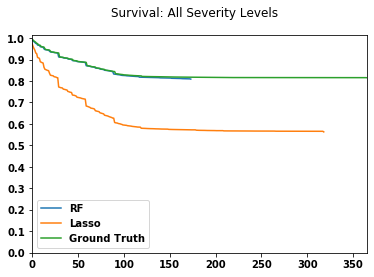

In [175]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: All Severity Levels','graphs/survival_all.png')

Subclinical Severity Survival Analysis

In [176]:
X = df[df.SUDSy_0 < 2]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(6868, 22) (6868,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [177]:
%%time
subclinical_concordance, gbsa, rsf, rcr = run_models(X, y, 'SUB')

RF Boosted score: 0.6466254178507088
(6868, 22) (6868,)
RF score: 0.637488979255762
Lasso score: 0.6693730726704226
CPU times: user 4min 20s, sys: 1.4 s, total: 4min 21s
Wall time: 4min 21s


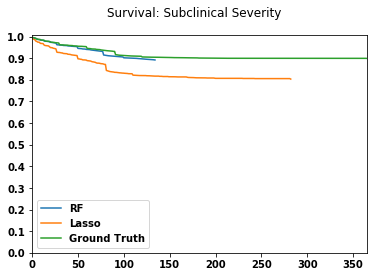

In [178]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Subclinical Severity', 'graphs/survival_subclinical.png')

In [179]:
subclinical_feature_importance_rf, subclinical_feature_importance_lasso = \
                                        get_feature_importance(X.columns, gbsa, rcr, 'SUB')

In [180]:
X = df[df.SUDSy_0 >= 2]
X = X[X.SUDSy_0 <= 5]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(6753, 22) (6753,)


In [181]:
%%time
mild_concordance, gbsa, rsf, rcr = run_models(X, y, 'MILD')

RF Boosted score: 0.5990589164309459
(6753, 22) (6753,)
RF score: 0.5868185722006121
Lasso score: 0.616243950048657
CPU times: user 4min 33s, sys: 2.69 s, total: 4min 36s
Wall time: 4min 43s


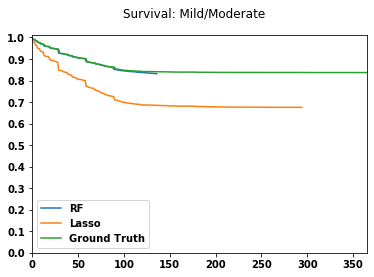

In [182]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Mild/Moderate', 'graphs/survival_mild.png')

In [183]:
mild_feature_importance_rf, mild_feature_importance_lasso = get_feature_importance(X.columns, gbsa, rcr, 'MILD')

Severe Severity Survival Analysis

In [184]:
X = df[df.SUDSy_0 > 5]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(7643, 22) (7643,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [185]:
%%time
severe_concordance, gbsa, rsf, rcr = run_models(X, y, 'SEVERE')

RF Boosted score: 0.6015789566269861
(7643, 22) (7643,)
RF score: 0.5862636086114124
Lasso score: 0.6062285094676074
CPU times: user 6min 32s, sys: 6.66 s, total: 6min 39s
Wall time: 7min 22s


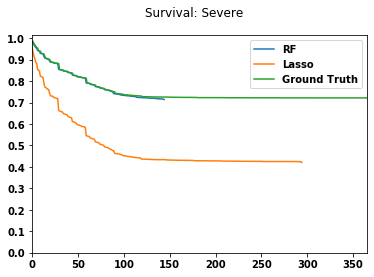

In [186]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Severe', 'graphs/survival_severe.png')

In [187]:
severe_feature_importance_rf, severe_feature_importance_lasso = get_feature_importance(X.columns, gbsa, rcr, 'SEVERE')

Overall Statistics

In [188]:
overall_concordance = pd.concat([subclinical_concordance, mild_concordance['MILD'], severe_concordance['SEVERE'],  
                                 full_concordance['ALL']], axis=1)
pd.DataFrame(data=overall_concordance)

,Model,SUB,MILD,SEVERE,ALL
0,Random Forest Boosted,0.646625,0.599059,0.601579,0.671256
1,Random Forest,0.637489,0.586819,0.586264,0.664250
2,Lasso,0.669373,0.616244,0.606229,0.678712
3,Dataset Size,6868.000000,6753.000000,7643.000000,21264.000000


In [189]:
overall_feature_importance_lasso = pd.merge(subclinical_feature_importance_lasso, \
                                            mild_feature_importance_lasso, on='Feature', how='outer')
overall_feature_importance_lasso = pd.merge(overall_feature_importance_lasso, \
                                            severe_feature_importance_lasso, on='Feature', how='outer')
overall_feature_importance_lasso.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_lasso, 2)

,Feature,SUB,SUB_abs,MILD,MILD_abs,SEVERE,SEVERE_abs
0,r4ag_0_cd,0.133731,0.133731,0.098171,0.098171,0.077213,0.077213
1,cjsig_0_cd,0.090351,0.090351,0.000000,0.000000,0.000000,0.000000
2,primsev_cd_2,-0.073248,0.073248,0.000000,0.000000,0.000000,0.000000
3,gvsg_cd,0.059173,0.059173,0.000000,0.000000,0.011590,0.011590
4,B2a_0g,0.045202,0.045202,0.000000,0.000000,0.000000,0.000000
5,dssg_0_cd,0.038917,0.038917,0.000000,0.000000,0.079549,0.079549
6,prsatx_cd,0.032776,0.032776,0.083595,0.083595,0.010027,0.010027
7,cdsg_0_cd,0.026800,0.026800,0.035255,0.035255,0.036975,0.036975
,Feature,SUB,SUB_abs,MILD,MILD_abs,SEVERE,SEVERE_abs
8,nonwhite_cd,-0.021622,0.021622,-0.045053,0.045053,-0.011584,0.011584


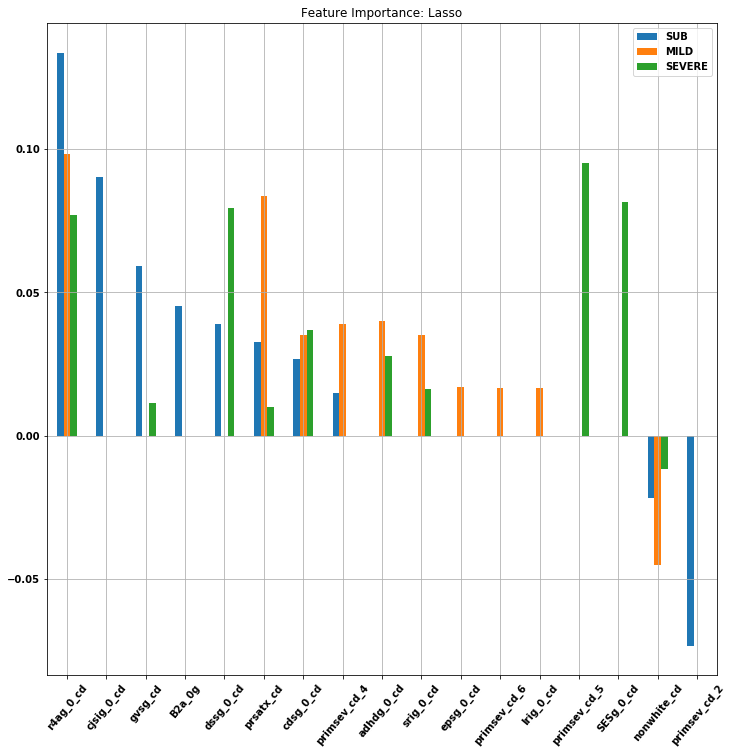

In [190]:
# feature importance for lasso across all ages
plt.rcParams["font.weight"] = "bold"

df = pd.DataFrame({'SUB': overall_feature_importance_lasso['SUB'].tolist(),
                   'MILD': overall_feature_importance_lasso['MILD'].tolist(),
                   'SEVERE': overall_feature_importance_lasso['SEVERE'].tolist()},
                  index=overall_feature_importance_lasso['Feature'].tolist())
df.sort_values(by=['SUB','MILD','SEVERE'], ascending=False, inplace=True)
ax = df.plot.bar(rot=50, figsize=(12, 12))
ax.grid()
ax.set_title('Feature Importance: Lasso')
fig = ax.get_figure()
    
fig.savefig('graphs/feature_importance_lasso.png', bbox_inches='tight')

In [191]:
overall_feature_importance_rf = pd.merge(subclinical_feature_importance_rf, mild_feature_importance_rf, on='Feature', how='outer')
overall_feature_importance_rf = pd.merge(overall_feature_importance_rf, severe_feature_importance_rf, on='Feature', how='outer')
overall_feature_importance_rf.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_rf, 4)

,Feature,SUB,MILD,SEVERE
0,r4ag_0_cd,0.201450,0.123635,0.150882
1,cjsig_0_cd,0.123550,0.000000,0.000000
2,B2a_0g,0.105482,0.000000,0.000000
3,gvsg_cd,0.086449,0.000000,0.025847
,Feature,SUB,MILD,SEVERE
4,primsev_cd_5,0.077188,0.000000,0.190235
5,primsev_cd_4,0.074447,0.090851,0.000000
6,prsatx_cd,0.061671,0.139707,0.000000
7,primsev_cd_2,0.061636,0.000000,0.000000
,Feature,SUB,MILD,SEVERE


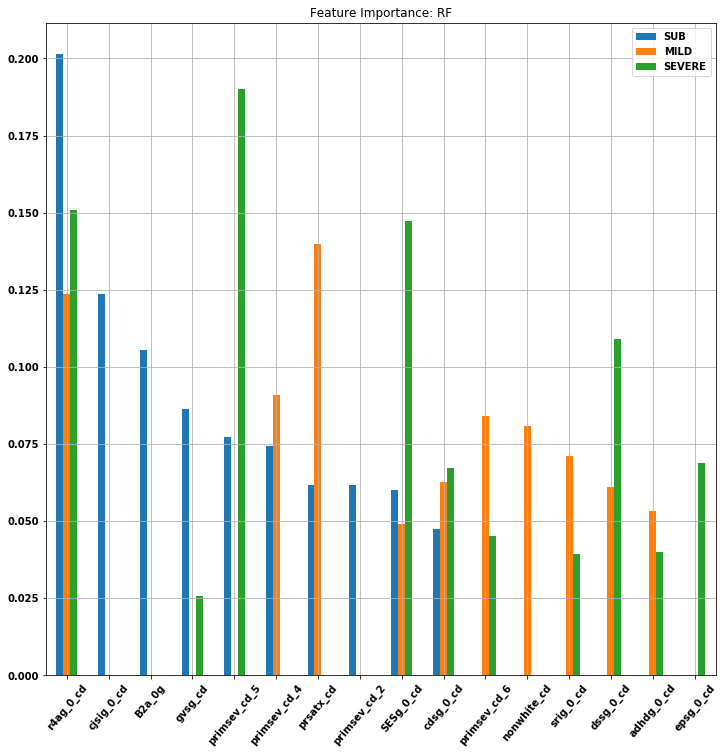

In [192]:
# feature importance for rf across all ages
df = pd.DataFrame({'SUB': overall_feature_importance_rf['SUB'].tolist(),
                   'MILD': overall_feature_importance_rf['MILD'].tolist(),
                   'SEVERE': overall_feature_importance_rf['SEVERE'].tolist()},
                  index=overall_feature_importance_rf['Feature'].tolist())
df.sort_values(by=['SUB','MILD','SEVERE'], ascending=False, inplace=True)
ax = df.plot.bar(rot=50, figsize=(12, 12))
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('graphs/feature_importance_rf.png', bbox_inches='tight')

In [193]:
# features in top 10 of both models across all ages
feature_importance_intersection = np.intersect1d(overall_feature_importance_rf['Feature'], 
                                                 overall_feature_importance_lasso['Feature'])
print('Common Features:', *list(feature_importance_intersection), sep =', ')

Common Features:, B2a_0g, SESg_0_cd, adhdg_0_cd, cdsg_0_cd, cjsig_0_cd, dssg_0_cd, epsg_0_cd, gvsg_cd, nonwhite_cd, primsev_cd_2, primsev_cd_4, primsev_cd_5, primsev_cd_6, prsatx_cd, r4ag_0_cd, srig_0_cd


In [194]:
# print out total notebook execution time
total_seconds = int(time.time() - start_time)
minutes = total_seconds // 60
seconds = total_seconds % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 62 minutes 10 seconds ---
